## Task 2 (75 points):
### In this task, you will pick a dataset (time-series or any other form of sequential data) and an associated problem that can be solved via sequence models. You must describe why you need sequence models to solve this problem. Include a link to the dataset source. Next, you should pick an RNN framework that you would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other Python Package).  


#### Part 1 (30 points): Implement your RNN either using an existing framework OR you can implement your own RNN cell structure. In either case, describe the structure of your RNN and the activation functions you are using for each time step and in the output layer. Define a metric you will use to measure the performance of your model (NOTE: Performance should be measured both for the validation set and the test set).

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0  129.0   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1  129.0   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2  129.0   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3  129.0   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4  129.0   -20 -12.0  1018.0   NW  12.97   0   0


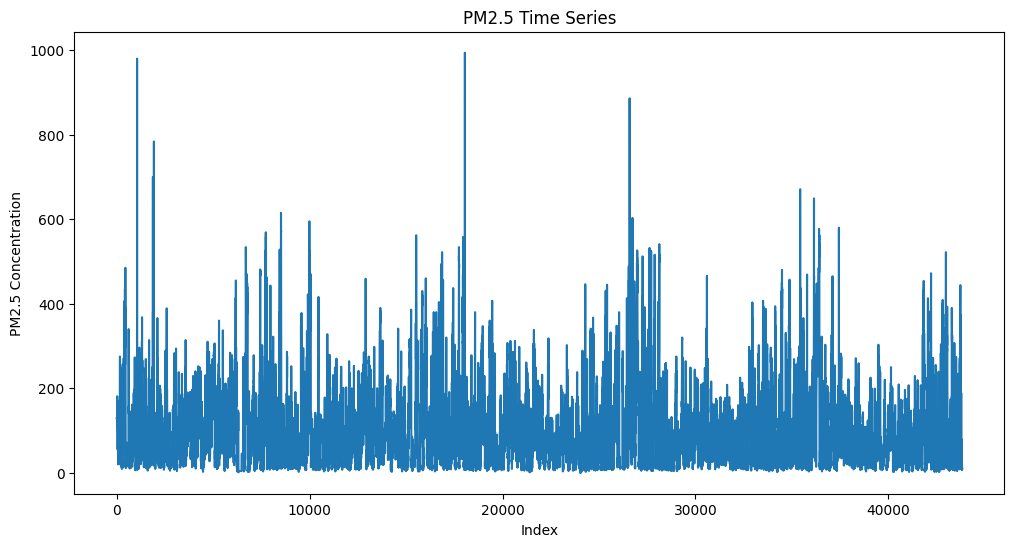

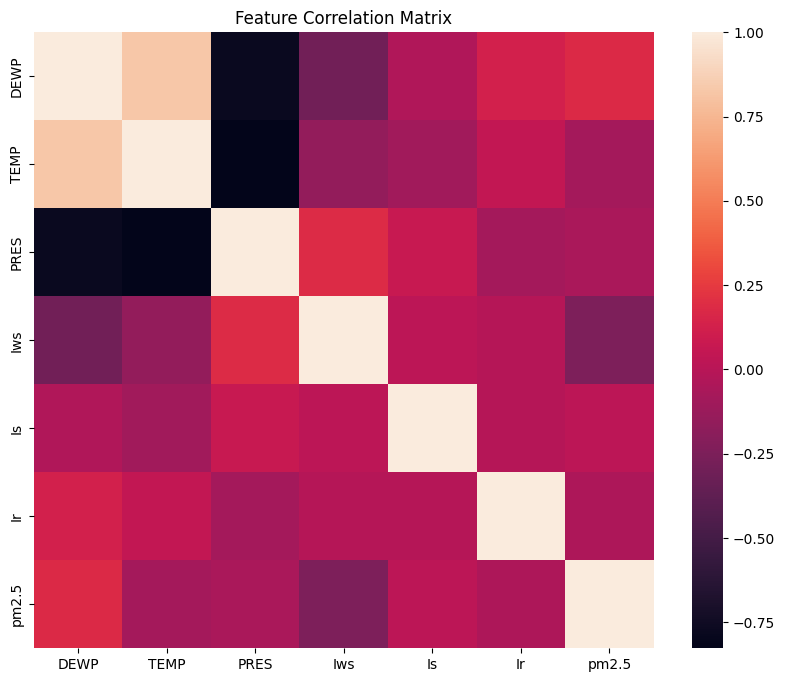

Epoch 1, Loss: 17808.845703125
Epoch 2, Loss: 17799.54296875
Epoch 3, Loss: 17790.359375
Epoch 4, Loss: 17781.208984375
Epoch 5, Loss: 17771.95703125
Epoch 6, Loss: 17762.439453125
Epoch 7, Loss: 17752.44921875
Epoch 8, Loss: 17741.7421875
Epoch 9, Loss: 17730.0390625
Epoch 10, Loss: 17717.021484375
Epoch 11, Loss: 17702.294921875
Epoch 12, Loss: 17685.3984375
Epoch 13, Loss: 17665.80859375
Epoch 14, Loss: 17642.99609375
Epoch 15, Loss: 17616.515625
Epoch 16, Loss: 17586.212890625
Epoch 17, Loss: 17552.486328125
Epoch 18, Loss: 17516.380859375
Epoch 19, Loss: 17479.318359375
Epoch 20, Loss: 17442.59375
Epoch 21, Loss: 17407.005859375
Epoch 22, Loss: 17372.849609375
Epoch 23, Loss: 17340.08984375
Epoch 24, Loss: 17308.595703125
Epoch 25, Loss: 17278.283203125
Epoch 26, Loss: 17249.146484375
Epoch 27, Loss: 17220.767578125
Epoch 28, Loss: 17192.51171875
Epoch 29, Loss: 17164.416015625
Epoch 30, Loss: 17136.97265625
Epoch 31, Loss: 17109.994140625
Epoch 32, Loss: 17083.185546875
Epoch 33,

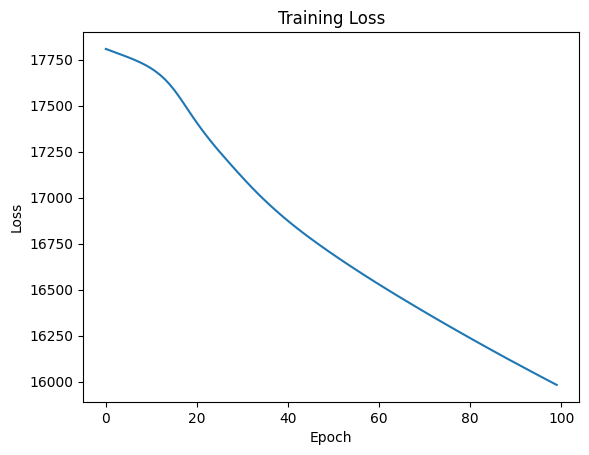

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


# RNN
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_num, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) 
        return out

def prepare_data(csv_file_path, sequence_length=24):
    data = pd.read_csv(csv_file_path)

    # dealing with missing values 
    data['pm2.5'] = data['pm2.5'].ffill()
    data['pm2.5'] = data['pm2.5'].bfill()
    
    print(data.head())

    # time series of pm2.5 
    plt.figure(figsize=(12, 6))
    plt.plot(data['pm2.5'])
    plt.title('PM2.5 Time Series')
    plt.xlabel('Index')
    plt.ylabel('PM2.5 Concentration')
    plt.show()
    

    features = data[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']].values
    labels = data['pm2.5'].values

    # heat map between features
    plt.figure(figsize=(10, 8))
    corr = data[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']].corr()
    sns.heatmap(corr)
    plt.title('Feature Correlation Matrix')
    plt.show()
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(labels[i])
    X, y = np.array(X), np.array(y)
    
    return train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = prepare_data('PRSA_data_2010.1.1-2014.12.31.csv')

# model
input_dim = X_train.shape[2]
hidden_dim = 64
output_dim = 1
layer_num = 1
model = RNNModel(input_dim, hidden_dim, output_dim, layer_num)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []

# train
num_epochs = 100  
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(torch.FloatTensor(X_train))
    loss = criterion(output.squeeze(), torch.FloatTensor(y_train))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
print()

# eval
model.eval()
with torch.no_grad():
    predictions = model(torch.FloatTensor(X_test))
    mse = mean_squared_error(y_test, predictions.numpy())
    rmse = np.sqrt(mse)
    print(f'Test MSE: {mse}, RMSE: {rmse}')


plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Part 2 (35 points): Update your network from part 1 with first an LSTM and then a GRU based cell structure (You can treat both as 2 separate implementations). Re-do the training and performance evaluation. What are the major differences you notice? Why do you think those differences exist between the 3 implementations (basic RNN, LSTM and GRU)?
#### Note: In part 1 and 2, you must perform sufficient data-visualization, pre-processing and/or feature-engineering if needed. The overall performance visualization of the loss function should also be provided.

LSTM: 
Epoch 10, Loss: 17743.21484375
Epoch 20, Loss: 17673.6484375
Epoch 30, Loss: 17316.3515625
Epoch 40, Loss: 16988.15625
Epoch 50, Loss: 16697.962890625
Epoch 60, Loss: 16455.478515625
Epoch 70, Loss: 16264.953125
Epoch 80, Loss: 16099.294921875
Epoch 90, Loss: 15947.716796875
Epoch 100, Loss: 15805.431640625
Test MSE: 16398.695650841728, RMSE: 128.05739201952275


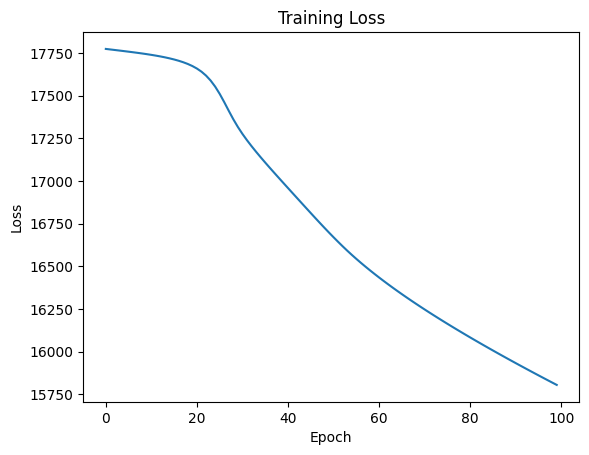

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


def prepare_data(csv_file_path, sequence_length=24):
    data = pd.read_csv(csv_file_path)
    data['pm2.5'] = data['pm2.5'].ffill()
    data['pm2.5'] = data['pm2.5'].bfill()

    features = data[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']].values
    labels = data['pm2.5'].values

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(labels[i])
    X, y = np.array(X), np.array(y)
    
    return train_test_split(X, y, test_size=0.2, random_state=42)


class LSTMMmodel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super(LSTMMmodel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, layer_num, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, hn = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


X_train, X_test, y_train, y_test = prepare_data('PRSA_data_2010.1.1-2014.12.31.csv')


def train_and_evaluate(model, X_train, y_train, X_test, y_test, num_epochs=100):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(torch.FloatTensor(X_train))
        loss = criterion(output.squeeze(), torch.FloatTensor(y_train))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    
    model.eval()
    with torch.no_grad():
        predictions = model(torch.FloatTensor(X_test))
        mse = mean_squared_error(y_test, predictions.numpy())
        rmse = np.sqrt(mse)
        print(f'Test MSE: {mse}, RMSE: {rmse}')
    
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    return model


# LSTM
input_dim = X_train.shape[2]
hidden_dim = 64
output_dim = 1
layer_num = 1

lstm_model = LSTMMmodel(input_dim, hidden_dim, output_dim, layer_num)
print("LSTM: ")
train_and_evaluate(lstm_model, X_train, y_train, X_test, y_test)
print()

GRU: 
Epoch 10, Loss: 17758.728515625
Epoch 20, Loss: 17697.02734375
Epoch 30, Loss: 17508.78125
Epoch 40, Loss: 16971.244140625
Epoch 50, Loss: 16701.734375
Epoch 60, Loss: 16514.50390625
Epoch 70, Loss: 16349.2783203125
Epoch 80, Loss: 16190.2666015625
Epoch 90, Loss: 16039.404296875
Epoch 100, Loss: 15893.828125
Test MSE: 16487.78779704029, RMSE: 128.40478105210994


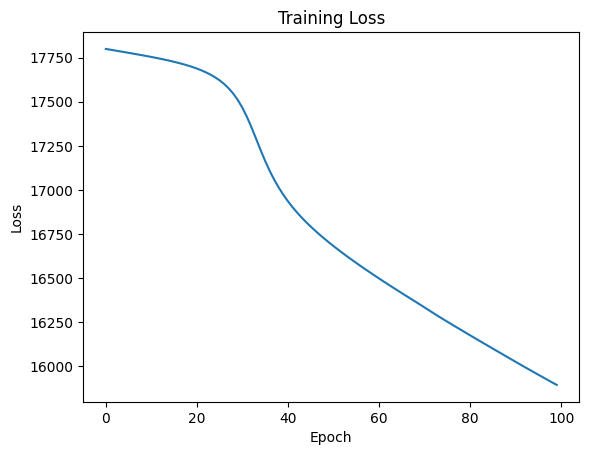

GRUModel(
  (gru): GRU(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [9]:
# GRU
print("GRU: ")
gru_model = GRUModel(input_dim, hidden_dim, output_dim, layer_num)
train_and_evaluate(gru_model, X_train, y_train, X_test, y_test)

Major differences:
1. Running time: LSTM and GRU are slower than RNN
2. Loss rate and pattern of decline: From RNN to LSTM and then to GRU, we observe differences in the speed and pattern of loss reduction. The loss reduction in RNN is relatively slow, whereas LSTM and GRU demonstrate a faster speed of loss reduction, especially in the early stages of training.
3. Final Performance: After 100 training epochs, the losses of both LSTM and GRU models are lower than that of the basic RNN model. On the test set, both the MSE and RMSE for LSTM and GRU are slightly lower than those for RNN, indicating their superior predictive performance.

#### Part 3 (10 points): Can you use the traditional feed-forward network to solve the same problem. Why or why not? (Hint: Can time series data be converted to usual features that can be used as input to a feed-forward network?) ?)